# VAE-WGAN MODEL WITH TRANSFORMER DETECTOR

### HELPER FUNCTIONS

In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
# =========================
# 1. Load & Utility Functions
# =========================


def load_csv_to_tensors(file_path):
    """
    Load a CSV file into PyTorch tensors with preprocessing.

    Label Encoding:
    - 0: NoEvent (marker = 41)
    - 1: Data Injection (marker in [7-12])
    - 2: Remote Trip (marker in [15-20])
    - 3: Relay Setting (marker in [21-40])
    - 4: Natural Event Type 1 (marker in [1-6])
    - 5: Natural Event Type 2 (marker in [13-14])
    """

    # Load dataset
    df = pd.read_csv(file_path)

    # Ensure 'marker' column exists
    if 'marker' not in df.columns:
        raise ValueError("Dataset must contain a 'marker' column for labels.")
    
    # Features to drop since they are just logs with no effect on the measured data
    features_to_drop = ["id",
        "R4-PA9:VH", "R2-PA9:VH", "snort_log1", "snort_log3",
        "control_panel_log3", "control_panel_log2", "control_panel_log1",
        "control_panel_log4", "snort_log2", "snort_log4"
    ]
    
    # Drop specified features (if they exist in the dataset)
    df = df.drop(columns=[col for col in features_to_drop if col in df.columns])
   
    # Extract features (X) and labels (y)
    X = df.drop(columns=['marker'])
    
    # Encode the marker column based on specified ranges
    def encode_marker(val):
        if val == 41:
            return 0  # NoEvent
        elif 7 <= val <= 12:
            return 1  # Data Injection
        elif 15 <= val <= 20:
            return 2  # Remote Trip
        elif 21 <= val <= 40:
            return 3  # Relay Setting
        elif 1 <= val <= 6:
            return 4  # Natural Event Type 1
        elif 13 <= val <= 14:
            return 5  # Natural Event Type 2
        else:
            raise ValueError(f"Unexpected marker value: {val}")

    y = df['marker'].apply(encode_marker).values.astype(np.float32)

    # 1. **Remove Constant Columns (All same values)**
    X = X.loc[:, (X.nunique() > 1)]
    
    # 2. **Remove Duplicate Columns**
    X = X.T.drop_duplicates().T
    
    # Convert to NumPy array
    X = X.values.astype(np.float32)

    # 3. **Handle infinite values**
    max_finite_values = np.nanmax(np.where(np.isfinite(X), X, np.nan), axis=0)
    for col in range(X.shape[1]):
        X[:, col] = np.where(np.isfinite(X[:, col]), X[:, col], max_finite_values[col])

    # 4. **Handle missing values (Replace NaNs with column mean)**
    col_means = np.nanmean(X, axis=0)
    for col in range(X.shape[1]):
        X[:, col] = np.where(np.isnan(X[:, col]), col_means[col], X[:, col])

    # Convert to PyTorch tensors
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)

    return X_tensor, y_tensor

def load_adbench_data(dataset_path):
    """
    Load dataset from a .npz file.
    Assumes the file contains:
    - 'X': Feature matrix (N, d)
    - 'y': Labels (N,)
    """
    data = np.load(dataset_path)
    X = data['X']
    y = data['y']
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

def evaluate_with_classification_report_and_auc(model, test_loader, device, threshold=0.5):
    """
    Evaluate a model using classification report and AUC-ROC metric.
    Args:
        model: Trained model to evaluate.
        test_loader: DataLoader for test data.
        device: Computation device (CPU/GPU).
        threshold: Threshold for binary classification.
    Returns:
        Classification report and AUC-ROC score.
    """
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch).squeeze()  # Predicted scores (B,)
            all_preds.append(y_pred.cpu())
            all_labels.append(y_batch.cpu())

    preds = torch.cat(all_preds).numpy()  # Flatten predictions
    labels = torch.cat(all_labels).numpy()  # Flatten labels

    # Convert predictions to binary labels
    binary_preds = (preds > threshold).astype(int)

    # Generate classification report
    report = classification_report(labels, binary_preds, target_names=['Class 0', 'Class 1'])
    print(report)

    # Calculate AUC-ROC if both classes are present
    if len(set(labels)) > 1:
        aucroc = roc_auc_score(labels, preds)
        print(f"AUC-ROC: {aucroc:.4f}")
    else:
        aucroc = None
        print("AUC-ROC: Undefined (only one class present in labels)")

    return report, aucroc

def log_to_file(file_path, message):
    """
    Append a log message to the specified file.
    Args:
        file_path: Path to the log file.
        message: Message to log.
    """
    with open(file_path, "a") as file:
        file.write(message + "\n")

def train_detector(model, train_loader, optimizer, criterion, device):
    """
    Train a detector model for one epoch.
    Args:
        model: Detector model to train.
        train_loader: DataLoader for training data.
        optimizer: Optimizer for model parameters.
        criterion: Loss function (e.g., BCE Loss).
        device: Computation device (CPU/GPU).
    Returns:
        Average loss over the epoch.
    """
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        y_pred = model(X_batch)
        
        y_batch = torch.tensor(y_batch,dtype=torch.long)
        loss = criterion(y_pred, y_batch)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(train_loader)


# Để tái lập trình ngẫu nhiên cho ví dụ
torch.manual_seed(0)
np.random.seed(0)

# Giả sử ta có một hàm tính reward liên quan đến "độ đa dạng" (diversity)
# Ở đây, tạm thời ta giả lập bằng cách random ra reward để minh hoạ.
def compute_diversity_reward(modified_z):
    # Tùy chỉnh cách tính reward thực tế.
    # Ở đây minh hoạ: reward tỉ lệ với độ lớn L2 norm của z (giả sử).
    return torch.norm(modified_z, p=2, dim=-1, keepdim=True)

# Hàm tiện ích chuyển numpy -> torch
def to_tensor(x, device="cpu", dtype=torch.float32):
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x)
    return x.to(device=device, dtype=dtype)

def One_Step_To_Feasible_Action(
        beta_cvae,
        detector,
        x_orig,
        device,
        previously_generated=None,
        alpha=1.0,
        lambda_div=0.1,
        lr=0.001,
        steps=50,
        log_file=None
):
    """
    Generate adversarial samples by modifying latent space representation.
    Args:
        beta_cvae: Trained Beta-CVAE model.
        detector: Trained detector model.
        x_orig: Original input data.
        device: Computation device (CPU/GPU).
        previously_generated: List of previously generated samples (for diversity).
        alpha: Scaling factor for diversity term.
        lambda_div: Weight for diversity term.
        lr: Learning rate for optimization.
        steps: Number of optimization steps.
        log_file: Path to log file for recording progress.
    Returns:
        Adversarial sample (torch.Tensor).
    """
    beta_cvae.eval()
    detector.eval()

    if previously_generated is None:
        previously_generated = []

    x_orig = x_orig.to(device).unsqueeze(0)  # Reshape to batch format (1, d)
    y_class1 = torch.full((1, 1), 0.8, device=device)  # Target class label (e.g., 0.8)

    # Encode input data into latent space
    with torch.no_grad():
        mean,logvar = beta_cvae.encode(x_orig, y_class1)
        z = beta_cvae.reparameterize(mean, logvar).detach().clone()

    # Optimize latent space representation
    optimizer_z = torch.optim.Adam([z], lr=lr)
    for step in range(steps):
        optimizer_z.zero_grad()

        # Decode latent variable back to data space
        x_synthetic = beta_cvae.decode(z, y_class1)

        # Calculate detector prediction
        prob_class1 = detector(x_synthetic)

        # Diversity term (if previous samples exist)
        if previously_generated:
            x_old_cat = torch.stack(previously_generated, dim=0).to(device)  # Stack previous samples (N, d)
            dist = torch.norm(x_synthetic - x_old_cat, p=2, dim=1)  # Pairwise distances
            diversity_term = torch.exp(-alpha * dist).sum()
        else:
            diversity_term = 0.0

        # Calculate total reward (inverse objective)
        inv_reward = prob_class1.mean() + lambda_div * diversity_term
        inv_reward.backward()
        optimizer_z.step()

    print(f"Deceiving Detector Reward: {1/ (prob_class1.item()+0.0001):.4f}",
          f"Diversity reward: {1/(diversity_term+0.0001):.4f}",
          f"Sample reward: {1/(inv_reward.item()+0.0001):.4f}")

    # Decode optimized latent variable back to data space
    with torch.no_grad():
        x_adv = beta_cvae.decode(z, y_class1).detach().cpu().squeeze(0)
    return x_adv



### Transformer Model

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.optim import Adam

class PositionalEncoding(nn.Module):
    """
    Add positional encoding to the input for sequential modeling.
    """

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)  # Add batch dimension

    def forward(self, x):
        """Add positional encoding to input tensor."""
        L = x.size(1)  # Sequence length
        return x + self.pe[:, :L, :].to(x.device)


class TransformerDetector(nn.Module):
    """
    Transformer-based detector model for anomaly or binary classification tasks.
    """

    def __init__(self, input_size, d_model=128, nhead=8, num_layers=2, dim_feedforward=256, dropout=0.1):
        super(TransformerDetector, self).__init__()
        self.embedding = nn.Linear(input_size, d_model)  # Input embedding layer
        self.positional_encoding = PositionalEncoding(d_model)  # Positional encoding

        # Transformer encoder layers
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model,
                                                   nhead=nhead,
                                                   dim_feedforward=dim_feedforward,
                                                   dropout=dropout,
                                                   batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Fully connected layers for classification
        self.fc = nn.Sequential(
            nn.Linear(d_model, 128),
            nn.ReLU(),
            nn.Linear(128, 6),
              # Output probability for binary classification
        )

    def forward(self, x):
        """Forward pass through the Transformer Detector."""
        if x.dim() == 2:
            x = x.unsqueeze(1)  # Add sequence dimension (B, 1, input_size)
        x = self.embedding(x)  # Project input to d_model dimensions
        x = self.positional_encoding(x)  # Add positional encoding
        x = self.transformer_encoder(x)  # Transformer encoder
        x = x.mean(dim=1)  # Aggregate features by averaging over sequence dimension
        return self.fc(x).squeeze(1)  # Output probabilities


### CVAE-WGAN MODEL

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

############################
# Conditional VAE–WGAN–GP
############################

class ConditionalVAEGenerator(nn.Module):
    """
    cVAE Generator for VAE–WGAN–GP:
      - Encoder: takes (x, y) -> outputs mean, logvar
      - Sample z from N(mean, exp(logvar))
      - Decoder: takes (z, y) -> reconstruct x
    """
    def __init__(self, input_dim, latent_dim=64, hidden_dim=128):
        super().__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        # Encoder: (x + label) -> hidden -> mean, logvar
        # We assume y is shape (B,1). So input_dim+1 total features for the encoder
        self.enc_fc1 = nn.Linear(input_dim + 1, hidden_dim)
        self.enc_fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.enc_mean = nn.Linear(hidden_dim, latent_dim)
        self.enc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder: (z + label) -> hidden -> reconstruct x
        self.dec_fc1 = nn.Linear(latent_dim + 1, hidden_dim)
        self.dec_fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.dec_out = nn.Linear(hidden_dim, input_dim)

    def encode(self, x, y):
        # x: (B, input_dim), y: (B, 1)
        xy = torch.cat([x, y], dim=1)  # shape: (B, input_dim+1)
        h = F.relu(self.enc_fc1(xy))
        h = F.relu(self.enc_fc2(h))
        mean = self.enc_mean(h)
        logvar = self.enc_logvar(h)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def decode(self, z, y):
        # z: (B, latent_dim), y: (B,1)
        zy = torch.cat([z, y], dim=1)  # shape: (B, latent_dim+1)
        h = F.relu(self.dec_fc1(zy))
        h = F.relu(self.dec_fc2(h))
        x_recon = self.dec_out(h)
        return x_recon

    def forward(self, x, y):
        mean, logvar = self.encode(x, y)
        z = self.reparameterize(mean, logvar)
        x_recon = self.decode(z, y)
        return x_recon, mean, logvar


class ConditionalCritic(nn.Module):
    """
    Critic for WGAN-GP in data space:
      - Takes real/fake x plus label y -> outputs scalar score
    """
    def __init__(self, input_dim, hidden_dim=128):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(input_dim + 1, hidden_dim),
            nn.ReLU(True),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(True),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x, y):
        # x: (B, input_dim), y: (B,1)
        xy = torch.cat([x, y], dim=1)  # shape: (B, input_dim+1)
        return self.main(xy)



### C-VAE-WGAN HELPER FUNCTIONS

In [ ]:
def kl_divergence(mean, logvar):
    """
    KL divergence between q(z|x) and N(0,I):
    D_KL = 0.5 * sum( exp(logvar) + mean^2 - 1 - logvar )
    """
    return +0.5 * torch.sum(torch.exp(logvar) + mean**2 - 1.0 - logvar)

def reconstruction_loss(x_recon, x):
    """
    MSE or L1 for reconstruction. Here we use MSE.
    """
    return F.mse_loss(x_recon, x, reduction='sum')

def critic_wgan_loss(critic, real_x, real_y, fake_x, fake_y):
    """
    WGAN loss for critic:
      L_critic = -( E[critic(real)] - E[critic(fake)] )
    """
    real_score = critic(real_x, real_y)
    fake_score = critic(fake_x, fake_y)
    loss = -(real_score.mean() - fake_score.mean())
    return loss

def generator_wgan_loss(critic, fake_x, fake_y):
    """
    WGAN loss for generator:
      L_gen = - E[critic(fake)]
    """
    fake_score = critic(fake_x, fake_y)
    return -fake_score.mean()

def gradient_penalty(critic, real_x, fake_x, real_y, device, lambda_gp=10.0):
    """
    Gradient penalty in data space for WGAN-GP:
    Interpolate between real_x and fake_x, pass to critic,
    compute gradient norm wrt inputs, penalize deviation from 1.
    """
    alpha = torch.rand(real_x.size(0), 1, device=device)
    alpha = alpha.expand_as(real_x)
    interpolated = alpha * real_x + (1 - alpha) * fake_x
    interpolated = interpolated.detach().requires_grad_(True)

    # Use the same label for interpolation
    # (Often, you might blend real_y and fake_y, but let's keep it simple.)
    interpolated_score = critic(interpolated, real_y)

    grad_outputs = torch.ones_like(interpolated_score, device=device)
    grads = torch.autograd.grad(outputs=interpolated_score,
                                inputs=interpolated,
                                grad_outputs=grad_outputs,
                                create_graph=True,
                                retain_graph=True,
                                only_inputs=True)[0]
    grads_norm = grads.view(grads.size(0), -1).norm(2, dim=1)
    gp = lambda_gp * ((grads_norm - 1)**2).mean()
    return gp


def One_Step_To_Feasible_Action_CVAE_WGAN(
        loaded_cvae,
        loaded_critic,
        detector,
        x_orig,
        device,
        previously_generated=None,
        alpha=1.0,
        lambda_div=0.1,
        lr=0.001,
        steps=50,
        log_file=None
):
    """
    Generate adversarial samples by modifying latent space representation.
    Args:
        beta_cvae: Trained Beta-CVAE model.
        detector: Trained detector model.
        x_orig: Original input data.
        device: Computation device (CPU/GPU).
        previously_generated: List of previously generated samples (for diversity).
        alpha: Scaling factor for diversity term.
        lambda_div: Weight for diversity term.
        lr: Learning rate for optimization.
        steps: Number of optimization steps.
        log_file: Path to log file for recording progress.
    Returns:
        Adversarial sample (torch.Tensor).
    """
    
    detector.eval()

    if previously_generated is None:
        previously_generated = []

    x_orig = x_orig.to(device).unsqueeze(0)  # Reshape to batch format (1, d)
    y_class1 = torch.full((1, 1), 0.8, device=device)  # Target class label (e.g., 0.8)

    # Encode input data into latent space
    with torch.no_grad():
        mean,logvar = loaded_cvae.encode(x_orig, y_class1)
        z = loaded_cvae.reparameterize(mean, logvar).detach().clone()

    # Optimize latent space representation
    optimizer_z = torch.optim.Adam([z], lr=lr)
    for step in range(steps):
        optimizer_z.zero_grad()

        # Decode latent variable back to data space
        x_synthetic = loaded_cvae.decode(z, y_class1)

        # Calculate detector prediction
        prob_class1 = detector(x_synthetic)

        # Diversity term (if previous samples exist)
        if previously_generated:
            x_old_cat = torch.stack(previously_generated, dim=0).to(device)  # Stack previous samples (N, d)
            dist = torch.norm(x_synthetic - x_old_cat, p=2, dim=1)  # Pairwise distances
            diversity_term = torch.exp(-alpha * dist).sum()
        else:
            diversity_term = 0.0

        # Calculate total reward (inverse objective)
        inv_reward = prob_class1.mean() + lambda_div * diversity_term
        inv_reward.backward()
        optimizer_z.step()

    print(f"Deceiving Detector Reward: {1/ (prob_class1.item()+0.0001):.4f}",
          f"Diversity reward: {1/(diversity_term+0.0001):.4f}",
          f"Sample reward: {1/(inv_reward.item()+0.0001):.4f}")

    # Decode optimized latent variable back to data space
    with torch.no_grad():
        x_adv = loaded_cvae.decode(z, y_class1).detach().cpu().squeeze(0)
    return x_adv



In [7]:
def train_cVAEWGAN(
    generator, critic, train_loader,
    opt_gen, opt_critic,
    device,
    epochs=10,
    lambda_gp=10.0,
    critic_steps=5
):
    """
    Train the conditional VAE–WGAN–GP model.
    Args:
        generator (ConditionalVAEGenerator): cVAE generator
        critic (ConditionalCritic): WGAN critic
        train_loader (DataLoader): Dataloader returning (x, y)
        opt_gen, opt_critic: Optimizers for generator and critic
        device: 'cuda' or 'cpu'
        epochs (int): Number of training epochs
        lambda_gp (float): Gradient penalty weight
        critic_steps (int): Number of critic updates per generator update
    """
    generator.to(device)
    critic.to(device)

    for epoch in range(epochs):
        total_recon_loss = 0.0
        total_kl_loss = 0.0
        total_adv_loss = 0.0
        total_gp_loss = 0.0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device).unsqueeze(1)
            B = x.size(0)

            # =====================
            # 1) Train the critic
            # =====================
            for _ in range(critic_steps):
                opt_critic.zero_grad()

                # Forward pass through generator
                mean, logvar = generator.encode(x, y)
                z = generator.reparameterize(mean, logvar)
                x_fake = generator.decode(z, y).detach()

                # Critic WGAN loss
                critic_loss = critic_wgan_loss(critic, x, y, x_fake, y)
                gp = gradient_penalty(critic, x, x_fake, y, device, lambda_gp=lambda_gp)
                loss_critic = critic_loss + gp
                loss_critic.backward()
                opt_critic.step()

                total_gp_loss += gp.item()

            # =====================
            # 2) Train the generator (VAE + adv)
            # =====================
            opt_gen.zero_grad()

            x_recon, mean, logvar = generator(x, y)  # forward pass
            # VAE losses
            rec_loss = reconstruction_loss(x_recon, x)
            kl_loss_val = kl_divergence(mean, logvar)

            # Adversarial WGAN loss for generator
            # (We pass the newly computed x_recon as "fake")
            adv_loss = generator_wgan_loss(critic, x_recon, y)

            loss_gen = rec_loss + 0.55*kl_loss_val + 10*adv_loss
            loss_gen.backward()
            opt_gen.step()

            total_recon_loss += rec_loss.item()
            total_kl_loss += kl_loss_val.item()
            total_adv_loss += adv_loss.item()

        # Print epoch stats
        avg_recon = total_recon_loss / len(train_loader)
        avg_kl = total_kl_loss / len(train_loader)
        avg_adv = total_adv_loss / len(train_loader)
        avg_gp = total_gp_loss / len(train_loader)

        print(f"[Epoch {epoch+1}/{epochs}] "
              f"Recon: {avg_recon:.4f} | KL: {avg_kl:.4f} | Adv: {avg_adv:.4f} | GP: {avg_gp:.4f}")


### TRAINING CVAE-WGAN

Go through each minority label and oversample using the CVAE-WGAN and then you train the detector

In [12]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import os
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import umap
import torch
import numpy as np

# --------------------------------------------------
# Specify dataset path and device configuration
# --------------------------------------------------
dataset_path = r"multilclass1.csv"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --------------------------------------------------
# Step 4.1: Load and preprocess data
# --------------------------------------------------
X_all, y_all = load_csv_to_tensors(dataset_path)  # new preprocessing

input_dim = X_all.shape[1]
X_all = X_all
y_all = y_all
# Standardize features using StandardScaler
scaler = StandardScaler()
X_all = torch.tensor(scaler.fit_transform(X_all)).float()

# Split data into train and test sets
D_train_np, D_test_np, y_train_np, y_test_np = train_test_split(
    X_all.numpy(), y_all.numpy(), test_size=0.3, random_state=42, stratify=y_all
)
D_train = torch.tensor(D_train_np, dtype=torch.float32)
y_train = torch.tensor(y_train_np, dtype=torch.float32)
D_test  = torch.tensor(D_test_np, dtype=torch.float32)
y_test  = torch.tensor(y_test_np, dtype=torch.float32)

# Create DataLoader for training
train_dataset = TensorDataset(D_train, y_train)
train_loader  = DataLoader(train_dataset, batch_size=64, shuffle=True)
print("Before oversampling with cVAEGAN:")
unique, counts = np.unique(y_train.numpy(), return_counts=True)
print("Class distribution in training set:", dict(zip(unique, counts)))
# --------------------------------------------------
# Step 4.2: Initialize New Model (Conditional VAE–WGAN–GP) and Train It
# --------------------------------------------------
# Replace BetaCVAE with our new ConditionalVAEGenerator and initialize a latent critic.
cvaegan = ConditionalVAEGenerator(input_dim=input_dim, hidden_dim=128, latent_dim=64).to(device)
critic = ConditionalCritic(input_dim=input_dim, hidden_dim=512).to(device)

# Train the new model using our WAE-GAN training function
opt_gen = Adam(cvaegan.parameters(), lr=1e-4)
opt_critic = Adam(critic.parameters(), lr=1e-4)
num_epochs_cvae = 150
train_cVAEWGAN(cvaegan, critic, train_loader,
                   opt_gen, opt_critic,
                   device=device,
                   epochs=3,
                   lambda_gp=10.0,
                   critic_steps=5)

# --------------------------------------------------
# Step 4.3: Generate synthetic data to maximize diversity
# Instead of sampling z ~ Normal(0,1), sample z ~ Uniform([-2,2]) to increase coverage.
cvaegan.eval()
'''
# Separate minority and majority classes
minority_mask = (y_train == 1)
X_minority = D_train[minority_mask]
majority_mask = (y_train == 0)
X_majority = D_train[majority_mask]

# Calculate the number of synthetic samples to generate
num_generate = len(X_majority) - len(X_minority)

with torch.no_grad():
    # Generate latent variables uniformly within [-2,2]
    z_uniform = (torch.rand(num_generate, cvaegan.latent_dim) * 4.0) - 2.0
    z_uniform = z_uniform.to(device)
    # Assign synthetic labels (oversample minority class with y=1, here set to 0.9)
    y_synthetic_c = torch.full((num_generate, 1), 0.9, device=device)
    # Decode synthetic data
    X_synthetic2 = cvaegan.decode(z_uniform, y_synthetic_c)
    X_synthetic2 = X_synthetic2.cpu()

# Create labels for synthetic samples (label 1 for anomaly)
y_synthetic_labels = torch.ones(num_generate)
'''
unique_labels, counts = torch.unique(y_train, return_counts=True)
majority_idx = torch.argmax(counts)
majority_label = unique_labels[majority_idx].item()
majority_count = counts[majority_idx].item()

# Create a list of minority labels (all labels that are not the majority)
minority_labels = [int(label.item()) for label in unique_labels if int(label.item()) != majority_label]

X_synthetic_list = []
y_synthetic_list = []

# For each minority label, determine the number of samples to generate and create synthetic samples.
for label in minority_labels:
    minority_mask = (y_train == label)
    current_count = minority_mask.sum().item()
    num_generate = majority_count - current_count  # oversample to match the majority count
    if num_generate <= 0:
        continue  # Skip if this class is not in deficit.
    
    with torch.no_grad():
        # Generate latent vectors uniformly in [-2,2]
        z_uniform = (torch.rand(num_generate, cvaegan.latent_dim, device=device) * 4.0) - 2.0
        # Create synthetic labels for the current class (shape: (num_generate, 1))
        z_uniform=z_uniform.to(device)
        y_synthetic_c = torch.full((num_generate, 1), float(label), device=device)
        # Decode synthetic data using the beta_cvae decoder
        X_syn = cvaegan.decode(z_uniform, y_synthetic_c)
        X_syn = X_syn.cpu() 
    
    X_synthetic_list.append(X_syn)
    y_synthetic_list.append(torch.full((num_generate,), float(label)))

# Concatenate synthetic samples from all minority classes.
if X_synthetic_list:
    X_synthetic2 = torch.cat(X_synthetic_list, dim=0)
    y_synthetic_labels = torch.cat(y_synthetic_list, dim=0)
else:
    X_synthetic2 = None
    y_synthetic_labels = None

# For debugging: print shapes and counts.
print("Synthetic samples shape:", X_synthetic2.shape if X_synthetic2 is not None else None)
print("Synthetic labels shape:", y_synthetic_labels.shape if y_synthetic_labels is not None else None)

# Combine synthetic data with original training data
D_train_final = torch.cat([D_train, X_synthetic2], dim=0)
y_train_final = torch.cat([y_train, y_synthetic_labels], dim=0)

# --------------------------------------------------
# Step 4.4: Train TransformerDetector on the augmented dataset
# --------------------------------------------------
train_dataset_final = TensorDataset(D_train_final, y_train_final)
test_dataset = TensorDataset(D_test, y_test)
train_loader_final = DataLoader(train_dataset_final, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

print("After oversampling with cVAEGAN:")
unique, counts = np.unique(y_train_final.numpy(), return_counts=True)
print("Class distribution in training set:", dict(zip(unique, counts)))

model = TransformerDetector(input_size=input_dim).to(device)
optimizer_tf = Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
num_epochs_tf = 50
for epoch in range(num_epochs_tf):
    train_loss = train_detector(model, train_loader, optimizer_tf, criterion, device)
    print(f"[Transformer] Epoch {epoch+1}/{num_epochs_tf}, Loss={train_loss:.4f}")
    print("-" * 40)

# --------------------------------------------------
# Step 4.5: Save the Trained Models
# ----------------------------------------
save_dir = "./saved_models"
os.makedirs(save_dir, exist_ok=True)
# Save the trained cVAEGAN model
cvae_path = os.path.join(save_dir, "cvaegan.pth")
torch.save(cvaegan.state_dict(), cvae_path)
print(f"cVAEGAN model saved to: {cvae_path}")

crit_path = os.path.join(save_dir, "crit.pth")
torch.save(critic.state_dict(), crit_path)
print(f"Critic model saved to: {crit_path}")

# Save the trained TransformerDetector model
detector_path = os.path.join(save_dir, "transformer_detector.pth")
torch.save(model.state_dict(), detector_path)
print(f"TransformerDetector model saved to: {detector_path}")

print(len(D_train_np[y_train_np==1]))



Before oversampling with cVAEGAN:
Class distribution in training set: {0.0: 121, 1.0: 398, 2.0: 316, 3.0: 1992, 4.0: 464, 5.0: 185}
[Epoch 1/3] Recon: 7795.5984 | KL: 29.5340 | Adv: -0.4844 | GP: 8.3705
[Epoch 2/3] Recon: 7750.7571 | KL: 21.7813 | Adv: -0.8224 | GP: 9.7456
[Epoch 3/3] Recon: 7718.3457 | KL: 29.7726 | Adv: -0.7061 | GP: 10.1391
Synthetic samples shape: torch.Size([8476, 118])
Synthetic labels shape: torch.Size([8476])
After oversampling with cVAEGAN:
Class distribution in training set: {0.0: 1992, 1.0: 1992, 2.0: 1992, 3.0: 1992, 4.0: 1992, 5.0: 1992}


C:\Users\kumth\AppData\Local\Temp\ipykernel_19140\2498482026.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch,dtype=torch.long)


[Transformer] Epoch 1/50, Loss=0.9393
----------------------------------------
[Transformer] Epoch 2/50, Loss=0.4892
----------------------------------------
[Transformer] Epoch 3/50, Loss=0.2997
----------------------------------------
[Transformer] Epoch 4/50, Loss=0.2880
----------------------------------------
[Transformer] Epoch 5/50, Loss=0.2461
----------------------------------------
[Transformer] Epoch 6/50, Loss=0.2238
----------------------------------------
[Transformer] Epoch 7/50, Loss=0.1656
----------------------------------------
[Transformer] Epoch 8/50, Loss=0.1605
----------------------------------------
[Transformer] Epoch 9/50, Loss=0.1385
----------------------------------------
[Transformer] Epoch 10/50, Loss=0.1257
----------------------------------------
[Transformer] Epoch 11/50, Loss=0.1060
----------------------------------------
[Transformer] Epoch 12/50, Loss=0.1608
----------------------------------------
[Transformer] Epoch 13/50, Loss=0.1854
----------

### SAMPLING AND PLOTTING CVAE-WGAN SWIFTHYDRA ON MULTILCASS DATASET

In [ ]:
import os
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import random
from sklearn.preprocessing import StandardScaler
import umap

# Ví dụ đường dẫn
dataset_path = r"multilclass1.csv"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Lưu Beta-CVAE
# Đảm bảo thư mục lưu trữ tồn tại
save_dir = "./saved_models"
cvae_path = os.path.join(save_dir, "cvaegan.pth")
critic_path = os.path.join(save_dir,"crit.pth")
detector_path = os.path.join(save_dir, "transformer_detector.pth")

# 4.1: Load Data
X_all, y_all = load_csv_to_tensors(dataset_path) # this loads data from the specified path woith preprocessing

input_dim = X_all.shape[1]
scaler = StandardScaler()
X_all = torch.tensor(scaler.fit_transform(X_all)).float()

# Chia train/test
D_train_np, D_test_np, y_train_np, y_test_np = train_test_split(
    X_all.numpy(), y_all.numpy(), test_size=0.6, random_state=42, stratify=y_all
)

D_train = torch.tensor(D_train_np, dtype=torch.float32)
y_train = torch.tensor(y_train_np, dtype=torch.float32)
D_test  = torch.tensor(D_test_np,  dtype=torch.float32)
y_test  = torch.tensor(y_test_np,  dtype=torch.float32)
print(D_train.shape)
# DataLoader cho Beta-CVAE
train_dataset = TensorDataset(D_train, y_train)
train_loader  = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Khởi tạo mô hình cùng cấu hình ban đầu
loaded_cvaegan = ConditionalVAEGenerator(input_dim=input_dim, hidden_dim=128, latent_dim=64).to(device)
loaded_critic = ConditionalCritic(input_dim=input_dim, hidden_dim=512).to(device)
loaded_detector_model = TransformerDetector(input_size=input_dim).to(device)

# Load trạng thái mô hình đã lưu
# Chỉ load trọng số
loaded_cvaegan.load_state_dict(torch.load(cvae_path, weights_only=True))
loaded_critic.load_state_dict(torch.load(critic_path, weights_only=True))
loaded_detector_model.load_state_dict(torch.load(detector_path, weights_only=True))

# Đặt mô hình về chế độ eval (nếu chỉ sử dụng inference)
loaded_critic.eval()
loaded_cvaegan.eval()
loaded_detector_model.eval()

print("Models loaded successfully.")


num_episodes = 100
num_gen_data = 50
batch_size = 128
new_detector = TransformerDetector(input_size=input_dim).to(device)
opt_gen = Adam(loaded_cvaegan.parameters(), lr=1e-4)
opt_critic = Adam(loaded_critic.parameters(), lr=1e-4)
optimizer_detector = Adam(new_detector.parameters(), lr=1e-4)
criterion = nn.BCELoss()
# File log
log_dir = "./logs"
os.makedirs(log_dir, exist_ok=True)
beta_cvae_log = os.path.join(log_dir, "beta_cvae.log")
detector_log = os.path.join(log_dir, "detector.log")
adversarial_log = os.path.join(log_dir, "adversarial_samples.log")
synthetic_data = []
start_idx = 0  # Vị trí bắt đầu ban đầu

for ep in range(num_episodes):
    # Lấy mask cho class 1
    class1_mask = (y_train == 1)  # Boolean tensor: True nếu y_train[i] == 1
    class0_mask = (y_train == 0)  # Boolean tensor: True nếu y_train[i] == 0

    # Đếm số lượng phần tử của mỗi class
    num_class1 = class1_mask.sum().item()
    num_class0 = class0_mask.sum().item()

    # Kiểm tra nếu số lượng class 1 vượt quá class 0, thoát vòng lặp
    if num_class1 > num_class0:
        print(f"Break at Episode {ep + 1}: Class 1 ({num_class1}) exceeds Class 0 ({num_class0}).")
        break
    # Lọc các mẫu thuộc class 1 từ D_train
    # Lọc các mẫu thuộc class 1 từ D_train
    D_train_grow_tensor = D_train[class1_mask]  # Tensor chứa tất cả các mẫu class 1
    # Chuyển mỗi hàng thành một tensor và lưu vào list
    D_train_grow = [row for row in D_train_grow_tensor]
    print(f"===== EPISODE {ep + 1}/{num_episodes} =====")

    # Train Beta-CVAE
    train_dataset = TensorDataset(D_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    num_epochs_cvae = 10
    train_cVAEWGAN(loaded_cvaegan, loaded_critic, train_loader,
                   opt_gen, opt_critic,
                   device=device,
                   epochs=5,
                   lambda_gp=10.0,
                   critic_steps=5)
    detector_epochs = 5
    train_dataset_detector = TensorDataset(D_train, y_train)
    train_loader_detector = DataLoader(train_dataset_detector, batch_size=batch_size, shuffle=True)
    for det_epoch in range(detector_epochs):
        detector_loss = train_detector(new_detector, train_loader_detector, optimizer_detector, criterion, device)
        # Giả sử y_train có dạng 0/1
    # print(f"===== Evaluate in Testing set =====")
    # evaluate_with_classification_report_and_auc(model, test_loader, device, threshold=0.5)
    # Generate Adversarial Samples
    idx_class1 = (y_train == 1).nonzero(as_tuple=True)[0]
    new_samples, new_labels = [], []
    # Lấy các index từ idx_class1, xử lý wrap-around nếu cần
    end_idx = start_idx + num_gen_data
    indices = idx_class1[start_idx:end_idx]

    # Nếu vượt quá độ dài của idx_class1, quay lại từ đầu
    if end_idx > len(idx_class1):
        indices += idx_class1[:end_idx - len(idx_class1)]

    # Cập nhật vị trí bắt đầu cho vòng lặp tiếp theo

    start_idx = end_idx % len(idx_class1)
    for syn_data in range(num_gen_data):
        unique, counts = np.unique(y_train.numpy(), return_counts=True)
        print("Phân phối lớp trong tập train:", dict(zip(unique, counts)))
        print("===== Generated Data {} =====".format(syn_data))
        random_idx = random.choice(idx_class1)
        x_orig = D_train[random_idx]
        x_adv = One_Step_To_Feasible_Action_CVAE_WGAN(
            loaded_cvae=loaded_cvaegan,
            loaded_critic=loaded_critic,
            detector=loaded_detector_model,
            x_orig=x_orig,
            device=device,
            previously_generated=D_train_grow,
            alpha=1.0,
            lambda_div=0.1,
            lr=0.01,
            steps=20,
            log_file=adversarial_log,
        )
        new_samples.append(x_adv.unsqueeze(0))
        new_labels.append(torch.tensor([1]))
        synthetic_data.append(x_adv)
    new_samples = torch.cat(new_samples, dim=0)
    new_labels = torch.cat(new_labels, dim=0)
    D_train = torch.cat([D_train, new_samples], dim=0)
    y_train = torch.cat([y_train, new_labels], dim=0)

#___________________________________________________________
# 4.4: Visualize Generated Data



plt.style.use('default')  # Đảm bảo sử dụng style mặc định

D_train = torch.tensor(D_train_np, dtype=torch.float32)
y_train = torch.tensor(y_train_np, dtype=torch.float32)
D_test  = torch.tensor(D_test_np,  dtype=torch.float32)
y_test  = torch.tensor(y_test_np,  dtype=torch.float32)

X_synthetic2 = np.asarray(synthetic_data)
X_synthetic2 = torch.tensor(X_synthetic2,  dtype=torch.float32)

# 1) Gộp dữ liệu
X_plot = torch.cat([D_train, D_test, X_synthetic2], dim=0).numpy()

# Tạo nhãn:
# - Phần đầu: y_train (0 hoặc 1)
# - Tiếp theo: y_test (0 hoặc 1)
# - Cuối cùng: synthetic (2)
N_train = len(D_train)
N_test = len(D_test)
N_synthetic = len(X_synthetic2)
y_plot = np.concatenate([
    y_train.numpy(),            # Nhãn train
    y_test.numpy(),             # Nhãn test
    np.full((N_synthetic,), 2)  # Nhãn synthetic
], axis=0)

# 2) Chuẩn hoá dữ liệu (nếu cần)
scaler = StandardScaler()
X_plot_scaled = scaler.fit_transform(X_plot)

# 3) Tính UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, n_jobs=-1)

X_embedded = reducer.fit_transform(X_plot_scaled)
# X_embedded.shape = (N_train + N_test + N_synthetic, 2)

# 4) Vẽ
plt.figure(figsize=(10, 8), facecolor='white')  # Đặt nền trắng

# Train Class 0 -> đỏ
idx0_train = (y_plot[:N_train] == 0)
plt.scatter(X_embedded[:N_train][idx0_train, 0], X_embedded[:N_train][idx0_train, 1],
            c='darkred', alpha=0.6, label='Class 0 (Train)')

# Train Class 1 -> xanh dương
idx1_train = (y_plot[:N_train] == 1)
plt.scatter(X_embedded[:N_train][idx1_train, 0], X_embedded[:N_train][idx1_train, 1],
            c='darkblue', alpha=0.6, label='Class 1 (Train)')

# Test Class 0 -> cam
idx0_test = (y_plot[N_train:N_train + N_test] == 0)
plt.scatter(X_embedded[N_train:N_train + N_test][idx0_test, 0],
            X_embedded[N_train:N_train + N_test][idx0_test, 1],
            c='orange', alpha=0.6, label='Class 0 (Test)')

# Test Class 1 -> xanh nhạt
idx1_test = (y_plot[N_train:N_train + N_test] == 1)
plt.scatter(X_embedded[N_train:N_train + N_test][idx1_test, 0],
            X_embedded[N_train:N_train + N_test][idx1_test, 1],
            c='skyblue', alpha=0.6, label='Class 1 (Test)')

# Synthetic Data -> xanh lá
idx_syn = (y_plot[N_train + N_test:] == 2)
plt.scatter(X_embedded[N_train + N_test:][idx_syn, 0],
            X_embedded[N_train + N_test:][idx_syn, 1],
            c='green', alpha=0.6, label='Synthetic')

plt.title("UMAP Visualization: Train, Test, and Synthetic Data")
plt.legend()
plt.show()

#______________________________________________________
  # 4.4: Train mô hình TransformerDetector
train_dataset_final = TensorDataset(D_train, y_train)
test_dataset = TensorDataset(D_test, y_test)
train_loader_final = DataLoader(train_dataset_final, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)
print("Sau khi oversampling bằng VAE:")
unique, counts = np.unique(y_train.numpy(), return_counts=True)
print("Phân phối lớp trong tập train:", dict(zip(unique, counts)))

# model = MixtureOfExperts(input_size=input_dim, num_experts= 10)
model = TransformerDetector(input_size=input_dim).to(device)
optimizer_tf = Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()
num_epochs_tf = 100
score_total=0
for epoch in range(num_epochs_tf):
    train_loss = train_detector(model, train_loader_final, optimizer_tf, criterion, device)
    print(f"[Transformer] Epoch {epoch + 1}/{num_epochs_tf}, Loss={train_loss:.4f}")

    # Đánh giá
    print("Test set evaluation:")
    r, score = evaluate_with_classification_report_and_auc(model, test_loader, device, threshold=0.4)
    print("-" * 40) 

torch.Size([1986, 117])
Models loaded successfully.
Break at Episode 1: Class 1 (227) exceeds Class 0 (69).


KeyboardInterrupt: 

### EVALUATE ACCURACY

In [ ]:
import torch
num_epochs_tf = 100
for epoch in range(num_epochs_tf):
    train_loss = train_detector(model, train_loader, optimizer_tf, criterion, device)
    print(f"[Transformer] Epoch {epoch+1}/{num_epochs_tf}, Loss={train_loss:.4f}")
    print("-" * 40)
def evaluate_accuracy(model, test_loader, device):
    model.eval()  # set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device).long()  # ensure labels are long
            logits = model(X_batch)  # logits shape: (batch_size, 6)
            predicted = torch.argmax(logits, dim=1)  # predicted class indices
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
    accuracy = correct / total
    return accuracy

# Example usage:
accuracy = evaluate_accuracy(model, test_loader, device)
print("Test Accuracy:", accuracy)


### SAMPLING AND PLOTTING

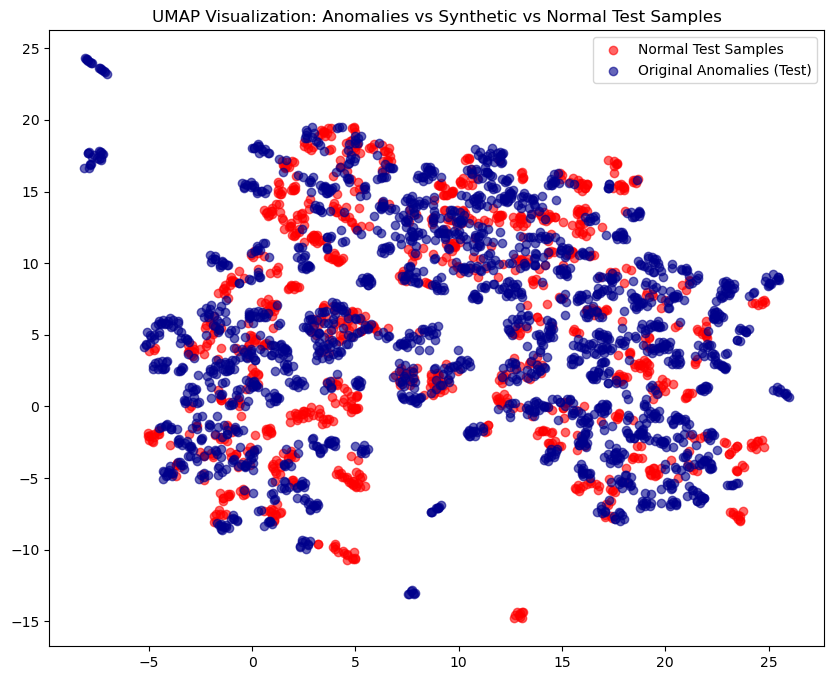

In [82]:
import numpy as np
import torch
import umap
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def generate_and_plot_anomaly_synthetic(D_train_np, y_train_np, D_test_np, y_test_np, loaded_wae, device, num_gen=300):
    """
    Generate synthetic anomaly samples using the conditional WAE (condition=1) from samples
    in D_train_np where y_train_np==1. Then, plot original anomalies, synthetic samples, 
    and normal test samples using UMAP.

    Parameters:
      D_train_np (np.array): Original training data (numpy array).
      y_train_np (np.array): Training labels (numpy array, with 1 for normal, 0 for anomaly).
      D_test_np (np.array): Test data (numpy array).
      y_test_np (np.array): Test labels (numpy array, with 1 for normal, 0 for anomaly).
      loaded_wae: Pre-trained conditional WAE model.
      device: Torch device.
      num_gen (int): Number of synthetic anomaly samples to generate.
    """
    # 1. Identify anomaly indices in the training data
    anomaly_indices = np.where(y_train_np == 0)[0]
    
    # 2. Randomly select num_gen samples from the anomaly subset
    random_indices = np.random.choice(anomaly_indices, size=num_gen, replace=True)
    x_anom = D_train_np[random_indices]  # Shape: (num_gen, input_dim)

    # 3. Create condition vector: since it's binary (anomaly), use 0.0 as condition.
    y_condition = torch.zeros((num_gen, 1), device=device)
    x_anom = torch.tensor(x_anom, dtype=torch.float32, device=device)

    # 4. Generate synthetic samples
    with torch.no_grad():
        mean, logvar = loaded_wae.encode(x_anom, y_condition)
        z = loaded_wae.reparameterize(mean, logvar)
        x_synthetic = loaded_wae.decode(z, y_condition).detach().cpu().numpy()
    
    # 5. Prepare data for UMAP visualization
    anomaly_data = D_test_np[y_test_np == 0]  # Original anomalies from test set
    normal_data = D_test_np[y_test_np == 1]   # Normal test samples
    synthetic_data = x_synthetic              # Generated synthetic anomalies

    # Concatenate for visualization
    X_plot = np.concatenate([anomaly_data, synthetic_data, normal_data], axis=0)

    # Standardize data before UMAP
    scaler_plot = StandardScaler()
    X_plot_scaled = scaler_plot.fit_transform(X_plot)

    # 6. Apply UMAP to reduce to 2D
    reducer = umap.UMAP(n_neighbors=15, min_dist=1, n_components=2, n_jobs=-1)
    X_embedded = reducer.fit_transform(X_plot_scaled)

    # 7. Create labels for plotting
    N_anom = anomaly_data.shape[0]
    N_syn = synthetic_data.shape[0]
    N_norm = normal_data.shape[0]
    y_plot = np.concatenate([
        np.ones(N_anom),      # Label 1 → Original anomalies
        np.full(N_syn, 2),    # Label 2 → Synthetic anomalies
        np.full(N_norm, 3)    # Label 3 → Normal test samples
    ])

    # 8. Plot using matplotlib
    plt.figure(figsize=(10, 8), facecolor='white')
    idx_anom = (y_plot == 1)
    idx_syn = (y_plot == 2)
    idx_norm = (y_plot == 3)
    plt.scatter(X_embedded[idx_norm, 0], X_embedded[idx_norm, 1], 
                c='red', alpha=0.6, label='Normal Test Samples')

    plt.scatter(X_embedded[idx_anom, 0], X_embedded[idx_anom, 1], 
                c='darkblue', alpha=0.6, label='Original Anomalies (Test)')
   


    plt.title("UMAP Visualization: Anomalies vs Synthetic vs Normal Test Samples")
    plt.legend()
    plt.show()

# Example usage:
# Assume D_train_np, y_train_np, D_test_np, y_test_np are already loaded as numpy arrays.
generate_and_plot_anomaly_synthetic(D_train_np, y_train_np, D_test_np, y_test_np, loaded_cvaegan, device, num_gen=300)
